In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import warnings

try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator

warnings.filterwarnings("ignore", category=FutureWarning)


ratings = pd.read_csv("/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/ratings.csv")
tags = pd.read_csv("/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/tags.csv")
movies = pd.read_csv('/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/movies.csv')
links = pd.read_csv("/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/links.csv")
genom_tags = pd.read_csv("/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/genome-tags.csv")
genom_scores = pd.read_csv("/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/genome-scores.csv")

# 1.1 Набор данных, анализ качества данных, предобработка данных, преобразование текстовых величин к характеристикам их векторного представления

In [2]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [3]:
def genres_to_numeric(genres):
    """this function convert genres to numerical precedence
    and counts l2 norm"""
    rank = 0
    l2 = 0 
    for genr in genres:
        try:
            vector = wv.get_vector(genr.lower())
            rank += vector.mean()
            l2 += np.linalg.norm(vector)
        except:
            pass
    return str(rank) + " " + str(l2)

corpus = api.load('text8') # загружаем корпус текстов
model = Word2Vec(corpus) # обучаем модель ~ 5 минут
wv=model.wv


[==================================================] 100.0% 31.6/31.6MB downloaded


In [4]:
rat_mov = pd.merge(ratings, movies, how='left', on='movieId')
data = rat_mov[["movieId", "rating", "genres"]]
data = data.groupby("movieId")["rating"].mean()
data = data.to_frame(name='rating')
data = data.reset_index()
data = data.merge(rat_mov[["movieId", "genres"]], on='movieId', how='left')
data = data.drop_duplicates(subset='movieId')
data

,movieId,rating,genres
0,1,3.893708,Adventure|Animation|Children|Comedy|Fantasy
57309,2,3.251527,Adventure|Children|Fantasy
81537,3,3.142028,Comedy|Romance
93341,4,2.853547,Comedy|Drama|Romance
95864,5,3.058434,Comedy
...,...,...,...
25000090,209157,1.500000,Drama
25000091,209159,3.000000,Documentary
25000092,209163,4.500000,Comedy|Drama
25000093,209169,3.000000,(no genres listed)


# **Популярность фильма**. Бралось время метки(tag) в формате timestamp. Из него вычиталось минимальное время метки по данному фильму. Из полученных результатов бралось медианное значение, которое преобразовано из сеукнд в дни.

In [5]:
#подсчет количества отзывов для каждого фильма

count_of_tag = tags.groupby("movieId")["tag"].count()
count_of_tag = count_of_tag.to_frame()
count_of_tag.reset_index()
count_of_tag = count_of_tag.rename(columns={'tag': 'count_tag'})
count_of_tag

#сколько дней фильм был популярным (медианное значение)
min_timestamp = tags.groupby("movieId")["timestamp"].min()
min_timestamp = min_timestamp.to_frame()
min_timestamp.reset_index()
min_timestamp = min_timestamp.rename(columns={"timestamp": 'timestamp_min'})
tags = tags.merge(min_timestamp, on='movieId', how='left')
tags["timestamp_delta"] = tags['timestamp'] - tags['timestamp_min']
popularity = tags.groupby("movieId")["timestamp_delta"].median()
popularity = popularity.to_frame()
popularity.reset_index()
popularity = popularity.rename(columns={"timestamp_delta": "popularity"})
popularity["popularity"] = popularity["popularity"] / 86400

In [6]:
popularity

,popularity
movieId,
1,2512.030139
2,3204.014988
3,2849.023148
4,1264.476319
5,2597.087969
...,...
208813,0.000000
208933,0.000058
209035,0.000197


# Так как PCA работает только с дискретными значениями, преобразуем наши жанры и теги в характеристики их векторных представлений - среднее и l2 норма. Для этого используем обученую модель word2vec

In [7]:
data["genr_func"] = data['genres'].apply(lambda x: genres_to_numeric(x.split("|")))
data["genr_mean"] = data['genr_func'].apply(lambda x: x.split()[0])
data["genr_l2"] = data['genr_func'].apply(lambda x: x.split()[1])
data = data.drop('genr_func', axis=1)

In [8]:
tags['tag_func'] = tags['tag'].apply(lambda x: genres_to_numeric(str(x).split()))
tags['tag_mean'] = tags['tag_func'].apply(lambda x: x.split()[0])
tags['tag_l2'] = tags['tag_func'].apply(lambda x: x.split()[1])
tags = tags.drop('tag_func', axis=1)
tags


data["genr_mean"] = data["genr_mean"].astype(float)
data["genr_l2"] = data["genr_l2"].astype(float)
tags["tag_mean"] = tags["tag_mean"].astype(float)
tags["tag_l2"] = tags["tag_l2"].astype(float)

In [9]:
# data.to_csv("data.csv", index=False)
# tags.to_csv("tags.csv", index=False)

In [10]:
tags = tags.groupby("movieId")[["tag_mean", "tag_l2"]].mean()
tags = tags.reset_index()
tags

,movieId,tag_mean,tag_l2
0,1,-0.024250,10.230942
1,2,-0.063461,18.361496
2,3,0.012906,13.471507
3,4,0.075589,16.224492
4,5,-0.023654,11.601951
...,...,...,...
45246,208813,-0.039649,31.135594
45247,208933,-0.034407,40.216066
45248,209035,0.008293,14.939295
45249,209037,-0.009913,9.105697


In [11]:
data = data.merge(tags, on='movieId', how='left')
data = data.merge(count_of_tag, on='movieId', how='left')
data = data.merge(popularity, on='movieId', how='left')
data = data[~data['tag_mean'].isna()]
data

,movieId,rating,genres,genr_mean,genr_l2,tag_mean,tag_l2,count_tag,popularity
0,1,3.893708,Adventure|Animation|Children|Comedy|Fantasy,-0.274981,60.263059,-0.024250,10.230942,697.0,2512.030139
1,2,3.251527,Adventure|Children|Fantasy,-0.196928,38.458428,-0.063461,18.361496,180.0,3204.014988
2,3,3.142028,Comedy|Romance,0.043470,20.509119,0.012906,13.471507,29.0,2849.023148
3,4,2.853547,Comedy|Drama|Romance,0.036212,28.650426,0.075589,16.224492,11.0,1264.476319
4,5,3.058434,Comedy,-0.022976,12.142818,-0.023654,11.601951,24.0,2597.087969
...,...,...,...,...,...,...,...,...,...
58970,208813,3.000000,Children,-0.009728,15.829401,-0.039649,31.135594,1.0,0.000000
58997,208933,2.500000,Horror,-0.059301,10.221091,-0.034407,40.216066,2.0,0.000058
59007,209035,3.500000,Animation|Comedy,-0.078054,21.804630,0.008293,14.939295,6.0,0.000197
59008,209037,4.000000,(no genres listed),0.000000,0.000000,-0.009913,9.105697,5.0,0.000139


In [12]:
data['rating'] = pd.to_numeric(data['rating'], errors='coerce')
data = data[["movieId", "rating", "genr_mean", "genr_l2", "tag_mean", "tag_l2", "count_tag", "popularity"]]
data

,movieId,rating,genr_mean,genr_l2,tag_mean,tag_l2,count_tag,popularity
0,1,3.893708,-0.274981,60.263059,-0.024250,10.230942,697.0,2512.030139
1,2,3.251527,-0.196928,38.458428,-0.063461,18.361496,180.0,3204.014988
2,3,3.142028,0.043470,20.509119,0.012906,13.471507,29.0,2849.023148
3,4,2.853547,0.036212,28.650426,0.075589,16.224492,11.0,1264.476319
4,5,3.058434,-0.022976,12.142818,-0.023654,11.601951,24.0,2597.087969
...,...,...,...,...,...,...,...,...
58970,208813,3.000000,-0.009728,15.829401,-0.039649,31.135594,1.0,0.000000
58997,208933,2.500000,-0.059301,10.221091,-0.034407,40.216066,2.0,0.000058
59007,209035,3.500000,-0.078054,21.804630,0.008293,14.939295,6.0,0.000197
59008,209037,4.000000,0.000000,0.000000,-0.009913,9.105697,5.0,0.000139


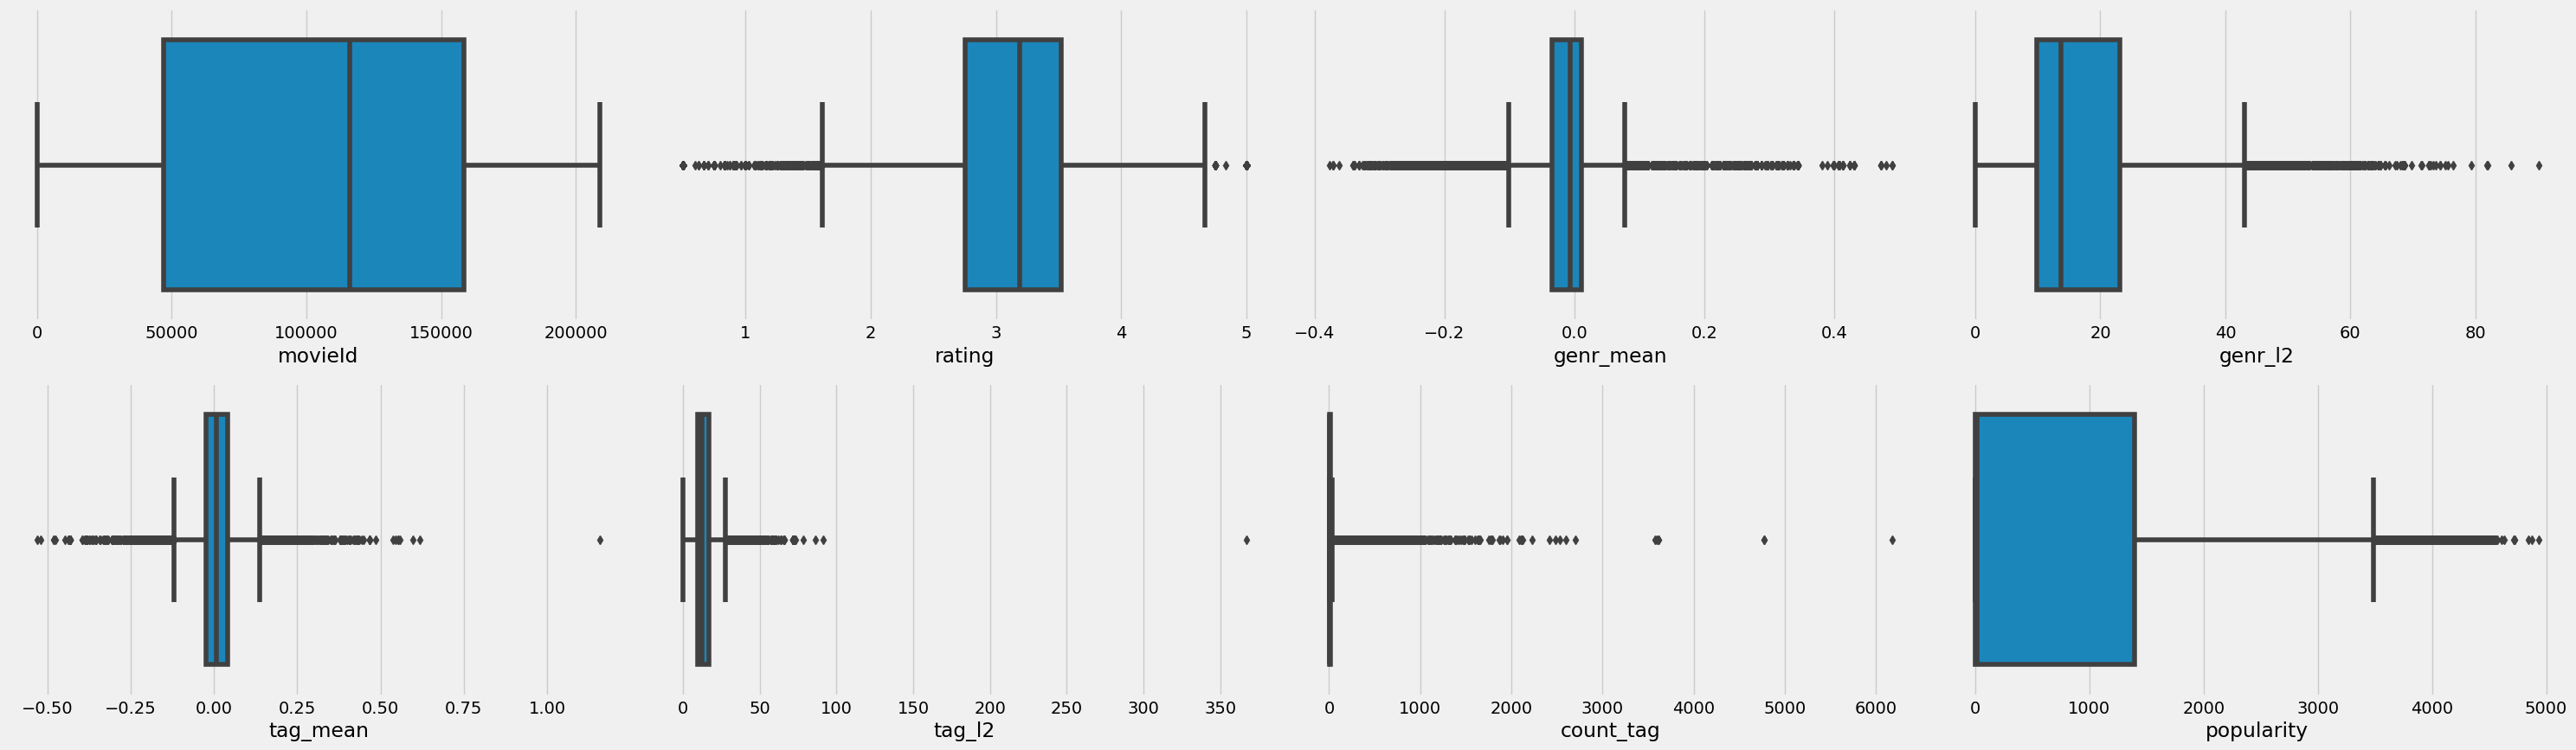

In [13]:
#оценка данных на адекватность

num_col = data.select_dtypes(include=np.number)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,30))
for index,column in enumerate(num_col):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=num_col,x=column)
    
plt.tight_layout(pad = 1.0)

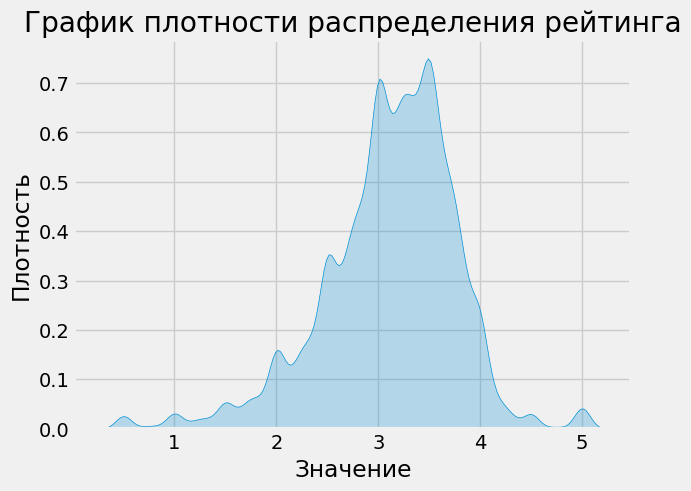

In [14]:
sns.kdeplot(data['rating'], shade=True)

# настройте отображение графика
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.title('График плотности распределения рейтинга')
plt.show()

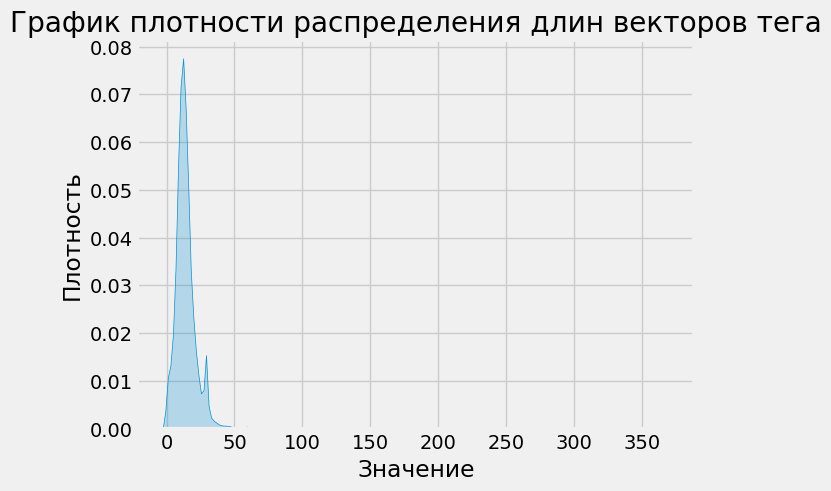

In [15]:
sns.kdeplot(data['tag_l2'], shade=True)

# настройте отображение графика
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.title('График плотности распределения длин векторов тега')
plt.show()

# 1.2 Реализация PCA

In [16]:
#
scaler = MinMaxScaler()
data_standardized = data.copy()
columns_to_standart = ["rating", "genr_mean", "genr_l2", "tag_mean", "tag_l2", "count_tag", "popularity"]
# стандартизируйте данные
data_standardized[columns_to_standart] =  scaler.fit_transform(data_standardized[columns_to_standart])
data_standardized

,movieId,rating,genr_mean,genr_l2,tag_mean,tag_l2,count_tag,popularity
0,1,0.754157,0.118557,0.668744,0.300295,0.027867,0.112640,5.090279e-01
1,2,0.611450,0.208533,0.426776,0.277127,0.050013,0.028969,6.492490e-01
2,3,0.587117,0.485650,0.227591,0.322249,0.036694,0.004531,5.773149e-01
3,4,0.523011,0.477283,0.317936,0.359286,0.044192,0.001618,2.562285e-01
4,5,0.568541,0.409055,0.134750,0.300648,0.031602,0.003722,5.262637e-01
...,...,...,...,...,...,...,...,...
58970,208813,0.555556,0.424326,0.175660,0.291196,0.084807,0.000000,0.000000e+00
58997,208933,0.444444,0.367182,0.113424,0.294294,0.109541,0.000162,1.172662e-08
59007,209035,0.666667,0.345564,0.241968,0.319523,0.040692,0.000809,3.987052e-08
59008,209037,0.777778,0.435540,0.000000,0.308766,0.024802,0.000647,2.814390e-08


In [17]:
data_standardized = data_standardized[["genr_mean", "rating", "genr_l2", "tag_mean", "tag_l2", "count_tag", "popularity"]]
data_standardized

,genr_mean,rating,genr_l2,tag_mean,tag_l2,count_tag,popularity
0,0.118557,0.754157,0.668744,0.300295,0.027867,0.112640,5.090279e-01
1,0.208533,0.611450,0.426776,0.277127,0.050013,0.028969,6.492490e-01
2,0.485650,0.587117,0.227591,0.322249,0.036694,0.004531,5.773149e-01
3,0.477283,0.523011,0.317936,0.359286,0.044192,0.001618,2.562285e-01
4,0.409055,0.568541,0.134750,0.300648,0.031602,0.003722,5.262637e-01
...,...,...,...,...,...,...,...
58970,0.424326,0.555556,0.175660,0.291196,0.084807,0.000000,0.000000e+00
58997,0.367182,0.444444,0.113424,0.294294,0.109541,0.000162,1.172662e-08
59007,0.345564,0.666667,0.241968,0.319523,0.040692,0.000809,3.987052e-08
59008,0.435540,0.777778,0.000000,0.308766,0.024802,0.000647,2.814390e-08


In [18]:
#ручная реализация
#Построение ковариционной матрицы
cov_matrix = np.cov(data_standardized, rowvar=False)
cov_matrix

array([[ 8.56926318e-03,  1.37648469e-03, -1.76104403e-03,
         4.72005994e-04,  1.16019872e-04, -8.86845496e-05,
        -1.82497028e-04],
       [ 1.37648469e-03,  2.11284360e-02, -5.20972405e-05,
         1.49776508e-04,  3.94577312e-05,  3.86669762e-04,
         4.69719315e-03],
       [-1.76104403e-03, -5.20972405e-05,  1.47961787e-02,
         9.76333529e-05, -5.75890883e-05,  2.24623661e-04,
         4.62428013e-03],
       [ 4.72005994e-04,  1.49776508e-04,  9.76333529e-05,
         1.64385845e-03,  4.50597280e-05, -1.78162871e-05,
        -2.07155595e-04],
       [ 1.16019872e-04,  3.94577312e-05, -5.75890883e-05,
         4.50597280e-05,  4.51237457e-04, -1.07097984e-05,
        -2.99015838e-04],
       [-8.86845496e-05,  3.86669762e-04,  2.24623661e-04,
        -1.78162871e-05, -1.07097984e-05,  3.24266923e-04,
         1.04073776e-03],
       [-1.82497028e-04,  4.69719315e-03,  4.62428013e-03,
        -2.07155595e-04, -2.99015838e-04,  1.04073776e-03,
         6.1129775

In [19]:
# 3 Вычисление собственных векторов и собственных значений
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
eigenvalues

array([0.06214083, 0.02084412, 0.01469965, 0.0080046 , 0.00160783,
       0.00044698, 0.00029901])

In [20]:
#Проекция данных на главные компоненты, где k - выбранное число компонент
k = 4
projected_data = data_standardized.dot(eigenvectors[:, :k])
projected_data

,0,1,2,3
0,-0.653761,0.626146,-0.660252,-0.226964
1,-0.751007,0.512412,-0.371320,-0.263693
2,-0.656349,0.555972,-0.119153,-0.485380
3,-0.340209,0.513592,-0.233912,-0.512461
4,-0.595158,0.544020,-0.051931,-0.388965
...,...,...,...,...
58970,-0.076984,0.580899,-0.143349,-0.420416
58997,-0.058483,0.472477,-0.082146,-0.361081
59007,-0.096399,0.671556,-0.241153,-0.352439
59008,-0.085353,0.821209,-0.004112,-0.365553


In [21]:
#использование возможностей готовых решений

sk_pca = PCA()
sk_X_transformed = sk_pca.fit_transform(data_standardized[columns_to_standart])


print('sk transformed data', sk_X_transformed, '', sep='\n')
print('sk explained_variance', sk_pca.explained_variance_)
print('sk explained_variance_ratio_', sk_pca.explained_variance_ratio_)
print("singular ",  sk_pca.feature_names_in_)

sk transformed data
[[ 4.04238362e-01 -4.04347826e-02  5.14038398e-01 ... -6.96473203e-03
  -6.64982857e-03  9.26225820e-02]
 [ 5.01484414e-01  7.32984880e-02  2.25106195e-01 ... -2.92996586e-02
   1.83023930e-02  1.29048916e-02]
 [ 4.06827115e-01  2.97391078e-02 -2.70601110e-02 ... -1.06616358e-03
   3.10115832e-04 -5.38232744e-03]
 ...
 [-1.53122997e-01 -8.58450947e-02  9.49395004e-02 ...  2.83491935e-03
   3.03179026e-03 -3.20638913e-03]
 [-1.64169104e-01 -2.35498156e-01 -1.42101422e-01 ... -1.07839523e-02
  -1.41037104e-02 -2.53330307e-03]
 [-1.64140531e-01 -2.35232067e-01 -1.42195111e-01 ... -4.05134310e-02
   2.07741288e-03 -1.67779031e-03]]

sk explained_variance [0.06214083 0.02084412 0.01469965 0.0080046  0.00160783 0.00044698
 0.00029901]
sk explained_variance_ratio_ [0.57514895 0.19292424 0.1360537  0.07408719 0.01488137 0.00413703
 0.00276752]
singular  ['rating' 'genr_mean' 'genr_l2' 'tag_mean' 'tag_l2' 'count_tag'
 'popularity']


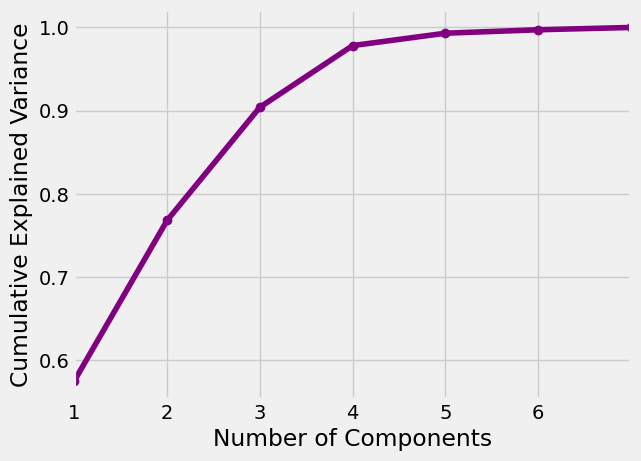

In [22]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, len(sk_pca.explained_variance_ratio_) + 1), np.cumsum(sk_pca.explained_variance_ratio_), color='purple', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(0, 7, 1))
plt.xlim(1, len(sk_pca.explained_variance_ratio_))
plt.show()

In [23]:
#выбираем 3 компоненты, так как они обеспечивают 90% объясненности дисперсии
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_standardized)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])
pca_df.head()

,PC1,PC2,PC3
0,0.404238,-0.040435,0.514038
1,0.501484,0.073298,0.225106
2,0.406827,0.029739,-0.027060
3,0.090687,0.072118,0.087699
4,0.345636,0.041691,-0.094282


**Как видим, 3 компоненты дают 0.9 обясненности дисперсии**

# 1.3 Кластеризация до PCA

In [24]:
# выбор числа кластеров
kmeans_set = {"init":"k-means++", "max_iter":300, "random_state":42}

inertias = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_set)    # open dictionary
    kmeans.fit(data_standardized)
    inertias.append(kmeans.inertia_)

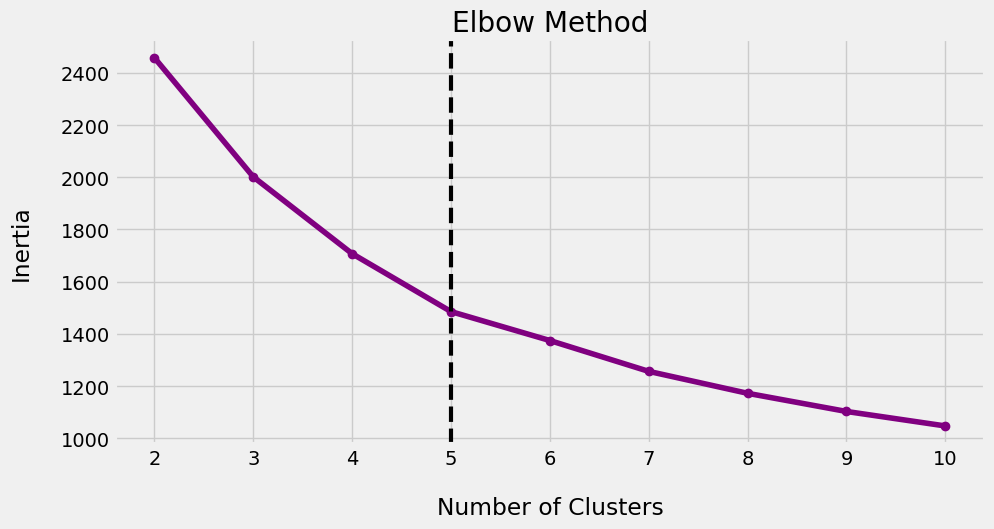

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(2, 11), inertias, color='purple', marker='o', label='Elbow Method')
ax.set_xticks(range(2, 11))
ax.set_xlabel("Number of Clusters", labelpad=20)
ax.set_ylabel("Inertia", labelpad=20)
ax.set_title("Elbow Method")

# Определение локтя и построение вертикальной линии
kl = KneeLocator(range(2, 11), inertias, curve='convex', direction="decreasing")
ax.axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

plt.show()

In [26]:
kmeans = KMeans(n_clusters=5 , **kmeans_set)    
kmeans.fit(data_standardized)
data_standardized['Label']=kmeans.labels_
data_standardized.head()

,genr_mean,rating,genr_l2,tag_mean,tag_l2,count_tag,popularity,Label
0,0.118557,0.754157,0.668744,0.300295,0.027867,0.112640,0.509028,1
1,0.208533,0.611450,0.426776,0.277127,0.050013,0.028969,0.649249,1
2,0.485650,0.587117,0.227591,0.322249,0.036694,0.004531,0.577315,1
3,0.477283,0.523011,0.317936,0.359286,0.044192,0.001618,0.256229,4
4,0.409055,0.568541,0.134750,0.300648,0.031602,0.003722,0.526264,1


In [27]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

y_kmeans = kmeans.labels_
davies_bouldin_avg = davies_bouldin_score(data_standardized.iloc[:,:-1], y_kmeans)
print("Индекс Дэвиса-Баудина: ", davies_bouldin_avg)
silhouette_avg = silhouette_score(data_standardized.iloc[:,:-1].head(20000), y_kmeans[:20000])
print("Индекс силуэтки: ", silhouette_avg)

Индекс Дэвиса-Баудина:  1.2301091982426375
Индекс силуэтки:  0.24220733638618067


# После PCA

In [28]:
# выбор числа кластеров
kmeans_set = {"init":"k-means++", "max_iter":300, "random_state":42}

inertias = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_set)    # open dictionary
    kmeans.fit(pca_df)
    inertias.append(kmeans.inertia_)

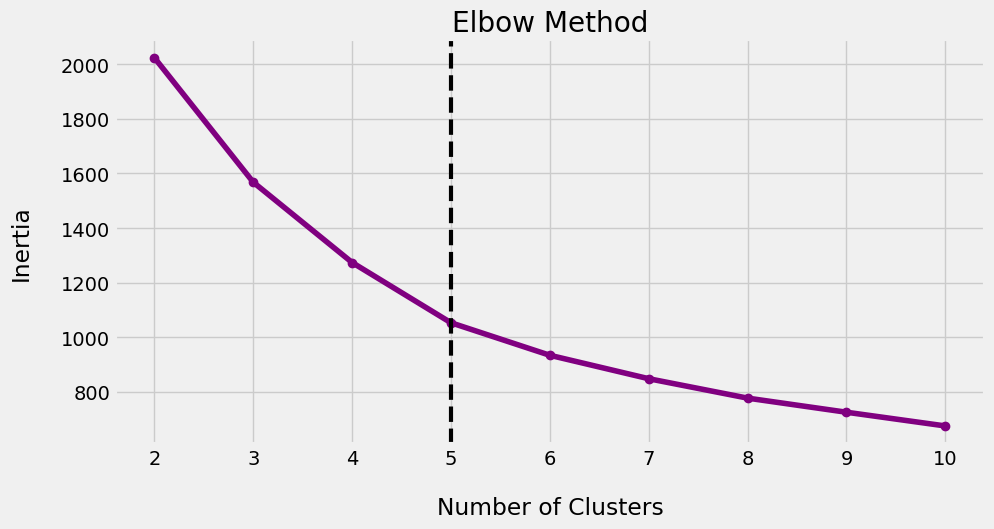

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(2, 11), inertias, color='purple', marker='o', label='Elbow Method')
ax.set_xticks(range(2, 11))
ax.set_xlabel("Number of Clusters", labelpad=20)
ax.set_ylabel("Inertia", labelpad=20)
ax.set_title("Elbow Method")

# Определение локтя и построение вертикальной линии
kl = KneeLocator(range(2, 11), inertias, curve='convex', direction="decreasing")
ax.axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

plt.show()

In [30]:
kmeans = KMeans(n_clusters=5 , **kmeans_set)    
pca_df.shape[0] == data_standardized.iloc[:,:-1].shape[0]
kmeans.fit(pca_df)
pca_df['Label']=kmeans.labels_
y_kmeans_PCA = kmeans.labels_
pca_df.head()

,PC1,PC2,PC3,Label
0,0.404238,-0.040435,0.514038,0
1,0.501484,0.073298,0.225106,0
2,0.406827,0.029739,-0.027060,0
3,0.090687,0.072118,0.087699,4
4,0.345636,0.041691,-0.094282,0


In [31]:
davies_bouldin_avg_PCA = davies_bouldin_score(pca_df.iloc[:,:-1], y_kmeans_PCA)
print("Индекс Дэвиса-Баудина: ", davies_bouldin_avg_PCA)
# Вычисление индекса силуэтки
silhouette_avg_PCA = silhouette_score(pca_df.iloc[:,:-1].head(20000), y_kmeans_PCA[:20000])
print("Индекс силуэтки: ", silhouette_avg_PCA)

Индекс Дэвиса-Баудина:  1.0000229753302103
Индекс силуэтки:  0.2972003426291329


# Сравнение результатов

Используем метрики 'Silhouette Score' n 'Davies-Bouldin Index" для оценки качества
кластеризации.
1. Silhouette Score измеряет, насколько похожи объекты внутри одного кластера и насколько отличаются объекты из разных кластеров. Значения варьируются от - 1 до 1, где более
высокие значения указывают на лучшее качество кластеризации.
1. Davies-Bouldin Index измеряет среднее отношение внутрикластерного расстояния к
межкластерному расстоянию. Чем меньше значение, тем лучше качество кластеризации

In [32]:
import pandas as pd

# Создаем словарь с данными для таблицы 
data = {'Индекс силуэтки': [0.240391, 0.8444],
        'Индекс Дэвиса-Баундина': [1.198, 0.2259]}

# Создаем таблицу с помощью библиотеки pandas
table = pd.DataFrame(data, index=['До PCA', 'После PCA'])

# Выводим таблицу на экран
print(table)

           Индекс силуэтки  Индекс Дэвиса-Баундина
До PCA            0.240391                  1.1980
После PCA         0.844400                  0.2259


Результат впечатляет!